# la Resting ECG de la clase dos es bernoulli! y la estamos tratando como multinomial

# Es mejor que cada una tenga su distribucion

In [240]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson

In [241]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [242]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [243]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [244]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

# sort df by class, later the Iwi[i] will be sorted by this order
df = df.sort_values(by=[df.columns[-1]])
df = df.reset_index(drop=True)

In [245]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

In [246]:
for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

In [247]:
for i in range(len(classes)):                   # For every class

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Poisson distribution
        if len(unique_values) < 6:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [248]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [331]:
def calculate_distribution(df):

    classes = df.iloc[:, -1].unique() # M
    total = len(df)                   # N
    attributes = df.columns           # X_i i \in {1, 2, ...}

    Iwi = []        # Table of instances for each class
    pwi = []        # a priori probability
    pxjIwi = []     # p(X_j|w_i) for each class

    for i in range(len(classes)):                   # For every class

        Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
        pwi.append(len(Iwi[i])/total)               # Append the a priori probability
        
        pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

        for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

            unique_values = Iwi[i][attribute].unique()

            # Poisson distribution
            if len(unique_values) < 5:
            # Test if the attribute is Poisson distributed
                mean = Iwi[i][attribute].mean()
                ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
                if ks_test.pvalue > 0.05:
                    lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                    un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

            # Multinomial distribution

            # Normal distribution
            else: 
                shapiro_test = shapiro(Iwi[i][attribute])
                if shapiro_test.pvalue > 0.05:
                    xbar = Iwi[i][attribute].mean()
                    s = Iwi[i][attribute].std()
                    un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

            # KDE distribution
                else:
                    un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

            pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

    return pxjIwi, Iwi, pwi, classes

In [332]:
def diagnostic(data, age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    pxjIwi, Iwi, pwi, classes = calculate_distribution(data)

    Pwis = []

    for clase in range(len(classes)):

        # Tienen que ir adentro porque los de la clase 3 no tienen Chest Pain Type 1

        Page = pxjIwi[clase][0].pdf(age)
        Psex = probability_categorical("Sex", sex, Iwi[clase])
        Pcpt = probability_categorical("Chest Pain Type", chest_pain_type, Iwi[clase])
        Prbp = pxjIwi[clase][3].pdf(resting_blood_pressure)
        Pcho = pxjIwi[clase][4].pdf(cholesterol)
        Pfbs = probability_categorical("Fasting Blood Sugar", fasting_blood_sugar, Iwi[clase])
        Prec = probability_categorical("Resting ECG", resting_ecg, Iwi[clase])
        Pmhr = pxjIwi[clase][7].pdf(max_heart_rate)
        Peia = probability_categorical("Exercise Induced Angina", exercise_induced_angina, Iwi[clase])
        Pstd = pxjIwi[clase][9].pdf(st_depression)
        Pslo = probability_categorical("Slope", slope, Iwi[clase])
        Pnmv = probability_categorical("Number of Major Vessels", number_of_major_vessels, Iwi[clase])
        # Ptal = pxjIwi[clase][12].evaluate(thal)
        
        Pwi = pwi[clase] * Page * Psex * Pcpt * Prbp * Pcho * Pfbs * Prec * Pmhr * Peia * Pstd * Pslo * Pnmv # * Ptal

        if type(Pwi) == np.ndarray:
            Pwi = Pwi[0]
        Pwis.append(Pwi)

        # print(f"Diagnosis of heart disease {clase} is {Pwi}")

    argmax = np.argmax(Pwis)
    print(f"The most likely diagnosis is {argmax}")

    return argmax

# Cross-Validation

## For All

In [251]:
for clase in range(len(classes)):
    Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

In [252]:
train = []
test = []

for clase in range(len(classes)):
    train.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8)])   # 80% of the rows
    test.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8)   :])   # 20% of the rows

In [253]:
train[0].head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,56.0,1.0,2.0,120.0,240.0,0.0,0.0,169.0,0.0,0.0,3.0,0.0,3.0,0
1,63.0,0.0,2.0,140.0,195.0,0.0,0.0,179.0,0.0,0.0,1.0,2.0,3.0,0
2,64.0,1.0,1.0,110.0,211.0,0.0,2.0,144.0,1.0,1.8,2.0,0.0,3.0,0
3,58.0,0.0,4.0,100.0,248.0,0.0,2.0,122.0,0.0,1.0,2.0,0.0,3.0,0
4,71.0,0.0,3.0,110.0,265.0,1.0,2.0,130.0,0.0,0.0,1.0,1.0,3.0,0


In [254]:
test[0].head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
128,54.0,0.0,2.0,132.0,288.0,1.0,2.0,159.0,1.0,0.0,1.0,1.0,3.0,0
129,45.0,1.0,4.0,115.0,260.0,0.0,2.0,185.0,0.0,0.0,1.0,0.0,3.0,0
130,62.0,0.0,4.0,140.0,394.0,0.0,2.0,157.0,0.0,1.2,2.0,0.0,3.0,0
131,69.0,1.0,1.0,160.0,234.0,1.0,2.0,131.0,0.0,0.1,2.0,1.0,3.0,0
132,54.0,1.0,4.0,140.0,239.0,0.0,0.0,160.0,0.0,1.2,1.0,0.0,3.0,0


#### aprendo a hacer cv

In [255]:
int(len(Iwi[0])*0.2)

32

In [256]:
fold1 = Iwi[1].iloc[int(len(Iwi[1])*0.0)   :   int(len(Iwi[1])*0.2)]
fold1

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,63.0,0.0,4.0,108.0,269.0,0.0,0.0,169.0,1.0,1.8,2.0,2.0,3.0,1
1,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0,1
2,46.0,1.0,4.0,120.0,249.0,0.0,2.0,144.0,0.0,0.8,1.0,0.0,7.0,1
3,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
4,65.0,1.0,4.0,110.0,248.0,0.0,2.0,158.0,0.0,0.6,1.0,2.0,6.0,1
5,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
6,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
7,60.0,1.0,4.0,130.0,253.0,0.0,0.0,144.0,1.0,1.4,1.0,1.0,7.0,1
8,52.0,1.0,4.0,128.0,255.0,0.0,0.0,161.0,1.0,0.0,1.0,1.0,7.0,1
9,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1


In [257]:
fold2 = Iwi[1].iloc[int(len(Iwi[1])*0.2)   :   int(len(Iwi[1])*0.4)]
fold2

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
11,62.0,1.0,4.0,120.0,267.0,0.0,0.0,99.0,1.0,1.8,2.0,2.0,7.0,1
12,60.0,0.0,4.0,158.0,305.0,0.0,2.0,161.0,0.0,0.0,1.0,0.0,3.0,1
13,62.0,0.0,4.0,150.0,244.0,0.0,0.0,154.0,1.0,1.4,2.0,0.0,3.0,1
14,58.0,1.0,2.0,120.0,284.0,0.0,2.0,160.0,0.0,1.8,2.0,0.0,3.0,1
15,47.0,1.0,4.0,150.0,226.0,0.0,0.0,98.0,1.0,1.5,2.0,0.0,7.0,1
16,52.0,1.0,4.0,112.0,230.0,0.0,0.0,160.0,0.0,0.0,1.0,1.0,3.0,1
17,64.0,1.0,3.0,140.0,335.0,0.0,0.0,158.0,0.0,0.0,1.0,0.0,3.0,1
18,54.0,1.0,2.0,192.0,283.0,0.0,2.0,195.0,0.0,0.0,1.0,1.0,7.0,1
19,56.0,1.0,4.0,120.0,100.0,0.0,0.0,120.0,1.0,1.5,2.0,0.0,7.0,1
20,61.0,0.0,4.0,145.0,307.0,0.0,2.0,146.0,1.0,1.0,2.0,0.0,7.0,1


In [258]:
fold3 = Iwi[1].iloc[int(len(Iwi[1])*0.4)   :   int(len(Iwi[1])*0.6)]
fold3

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
22,59.0,1.0,1.0,160.0,273.0,0.0,2.0,125.0,0.0,0.0,1.0,0.0,3.0,1
23,46.0,1.0,3.0,150.0,231.0,0.0,0.0,147.0,0.0,3.6,2.0,0.0,3.0,1
24,60.0,1.0,4.0,125.0,258.0,0.0,2.0,141.0,1.0,2.8,2.0,1.0,7.0,1
25,59.0,1.0,1.0,170.0,288.0,0.0,2.0,159.0,0.0,0.2,2.0,0.0,7.0,1
26,61.0,1.0,4.0,140.0,207.0,0.0,2.0,138.0,1.0,1.9,1.0,1.0,7.0,1
27,57.0,1.0,4.0,152.0,274.0,0.0,0.0,88.0,1.0,1.2,2.0,1.0,7.0,1
28,58.0,1.0,4.0,146.0,218.0,0.0,0.0,105.0,0.0,2.0,2.0,1.0,7.0,1
29,35.0,1.0,4.0,120.0,198.0,0.0,0.0,130.0,1.0,1.6,2.0,0.0,7.0,1
30,59.0,1.0,1.0,134.0,204.0,0.0,0.0,162.0,0.0,0.8,1.0,2.0,3.0,1
31,59.0,0.0,4.0,174.0,249.0,0.0,0.0,143.0,1.0,0.0,2.0,0.0,3.0,1


In [259]:
fold4 = Iwi[1].iloc[int(len(Iwi[1])*0.6)   :   int(len(Iwi[1])*0.8)]
fold4

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
33,40.0,1.0,4.0,152.0,223.0,0.0,0.0,181.0,0.0,0.0,1.0,0.0,7.0,1
34,44.0,1.0,4.0,110.0,197.0,0.0,2.0,177.0,0.0,0.0,1.0,1.0,3.0,1
35,50.0,1.0,3.0,140.0,233.0,0.0,0.0,163.0,0.0,0.6,2.0,1.0,7.0,1
36,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
37,61.0,0.0,4.0,130.0,330.0,0.0,2.0,169.0,0.0,0.0,1.0,0.0,3.0,1
38,67.0,1.0,3.0,152.0,212.0,0.0,2.0,150.0,0.0,0.8,2.0,0.0,7.0,1
39,47.0,1.0,3.0,108.0,243.0,0.0,0.0,152.0,0.0,0.0,1.0,0.0,3.0,1
40,58.0,1.0,4.0,128.0,216.0,0.0,2.0,131.0,1.0,2.2,2.0,3.0,7.0,1
41,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
42,48.0,1.0,2.0,110.0,229.0,0.0,0.0,168.0,0.0,1.0,3.0,0.0,7.0,1


In [260]:
fold5 = Iwi[1].iloc[int(len(Iwi[1])*0.8)   :   int(len(Iwi[1])*1.0)]
fold5

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
44,64.0,1.0,3.0,125.0,309.0,0.0,0.0,131.0,1.0,1.8,2.0,0.0,7.0,1
45,56.0,1.0,4.0,132.0,184.0,0.0,2.0,105.0,1.0,2.1,2.0,1.0,6.0,1
46,51.0,1.0,4.0,140.0,299.0,0.0,0.0,173.0,1.0,1.6,1.0,0.0,7.0,1
47,57.0,1.0,4.0,150.0,276.0,0.0,2.0,112.0,1.0,0.6,2.0,1.0,6.0,1
48,58.0,1.0,4.0,125.0,300.0,0.0,2.0,171.0,0.0,0.0,1.0,2.0,7.0,1
49,47.0,1.0,4.0,110.0,275.0,0.0,2.0,118.0,1.0,1.0,2.0,1.0,3.0,1
50,57.0,1.0,3.0,128.0,229.0,0.0,2.0,150.0,0.0,0.4,2.0,1.0,7.0,1
51,65.0,1.0,1.0,138.0,282.0,1.0,2.0,174.0,0.0,1.4,2.0,1.0,3.0,1
52,41.0,1.0,4.0,110.0,172.0,0.0,2.0,158.0,0.0,0.0,1.0,0.0,7.0,1
53,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [261]:
folds = 5
fold_size = 1/folds
fold_size

0.2

In [262]:
i=2
foldi = Iwi[1].iloc[int(len(Iwi[1]) * fold_size * i  )   :   int(len(Iwi[1]) * fold_size * (i+1))]
foldi

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
22,59.0,1.0,1.0,160.0,273.0,0.0,2.0,125.0,0.0,0.0,1.0,0.0,3.0,1
23,46.0,1.0,3.0,150.0,231.0,0.0,0.0,147.0,0.0,3.6,2.0,0.0,3.0,1
24,60.0,1.0,4.0,125.0,258.0,0.0,2.0,141.0,1.0,2.8,2.0,1.0,7.0,1
25,59.0,1.0,1.0,170.0,288.0,0.0,2.0,159.0,0.0,0.2,2.0,0.0,7.0,1
26,61.0,1.0,4.0,140.0,207.0,0.0,2.0,138.0,1.0,1.9,1.0,1.0,7.0,1
27,57.0,1.0,4.0,152.0,274.0,0.0,0.0,88.0,1.0,1.2,2.0,1.0,7.0,1
28,58.0,1.0,4.0,146.0,218.0,0.0,0.0,105.0,0.0,2.0,2.0,1.0,7.0,1
29,35.0,1.0,4.0,120.0,198.0,0.0,0.0,130.0,1.0,1.6,2.0,0.0,7.0,1
30,59.0,1.0,1.0,134.0,204.0,0.0,0.0,162.0,0.0,0.8,1.0,2.0,3.0,1
31,59.0,0.0,4.0,174.0,249.0,0.0,0.0,143.0,1.0,0.0,2.0,0.0,3.0,1


In [263]:
foldlist = []

for i in range(folds):
    foldi = Iwi[1].iloc[int(len(Iwi[1]) * fold_size * i  )   :   int(len(Iwi[1]) * fold_size * (i+1))]
    foldlist.append(foldi)

foldlist[0]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,63.0,0.0,4.0,108.0,269.0,0.0,0.0,169.0,1.0,1.8,2.0,2.0,3.0,1
1,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0,1
2,46.0,1.0,4.0,120.0,249.0,0.0,2.0,144.0,0.0,0.8,1.0,0.0,7.0,1
3,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
4,65.0,1.0,4.0,110.0,248.0,0.0,2.0,158.0,0.0,0.6,1.0,2.0,6.0,1
5,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
6,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
7,60.0,1.0,4.0,130.0,253.0,0.0,0.0,144.0,1.0,1.4,1.0,1.0,7.0,1
8,52.0,1.0,4.0,128.0,255.0,0.0,0.0,161.0,1.0,0.0,1.0,1.0,7.0,1
9,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1


In [264]:
train01 = pd.concat([foldlist[0], foldlist[1]])
train01

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,63.0,0.0,4.0,108.0,269.0,0.0,0.0,169.0,1.0,1.8,2.0,2.0,3.0,1
1,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0,1
2,46.0,1.0,4.0,120.0,249.0,0.0,2.0,144.0,0.0,0.8,1.0,0.0,7.0,1
3,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
4,65.0,1.0,4.0,110.0,248.0,0.0,2.0,158.0,0.0,0.6,1.0,2.0,6.0,1
5,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
6,63.0,0.0,4.0,124.0,197.0,0.0,0.0,136.0,1.0,0.0,2.0,0.0,3.0,1
7,60.0,1.0,4.0,130.0,253.0,0.0,0.0,144.0,1.0,1.4,1.0,1.0,7.0,1
8,52.0,1.0,4.0,128.0,255.0,0.0,0.0,161.0,1.0,0.0,1.0,1.0,7.0,1
9,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1


# me faltaban muchos!

In [294]:
for clase in range(len(classes)):
    Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

In [305]:
folds = 4 # 4 porque tenems 5 clases
fold_size = 1/folds
fold_size

0.25

In [306]:
foldlist = []

for omega in range(len(classes)):
    class_folds = []
    for i in range(folds):
        fold = Iwi[omega].iloc[int(len(Iwi[omega]) * fold_size * i) : int(len(Iwi[omega]) * fold_size * (i+1))]
        class_folds.append(fold)
    foldlist.append(class_folds)

In [311]:
foldlist[4][3]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
7,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4
8,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4
9,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0,4


In [312]:
#  F O L D S
# 00 01 02 03 C
# 10 11 12 13 L
# 20 21 22 23 A
# 30 31 32 33 S
# 40 41 42 43 S

train1 = pd.concat([foldlist[0][0], foldlist[0][1], foldlist[0][2], foldlist[1][0], foldlist[1][1], foldlist[1][2], foldlist[2][0], foldlist[2][1], foldlist[2][2], foldlist[3][0], foldlist[3][1], foldlist[3][2], foldlist[4][0], foldlist[4][1], foldlist[4][2]])
train1

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,65.0,1.0,4.0,120.0,177.0,0.0,0.0,140.0,0.0,0.4,1.0,0.0,7.0,0
1,45.0,1.0,4.0,104.0,208.0,0.0,2.0,148.0,1.0,3.0,2.0,0.0,3.0,0
2,64.0,1.0,1.0,170.0,227.0,0.0,2.0,155.0,0.0,0.6,2.0,0.0,7.0,0
3,51.0,1.0,3.0,94.0,227.0,0.0,0.0,154.0,1.0,0.0,1.0,1.0,7.0,0
4,46.0,1.0,2.0,101.0,197.0,1.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4
3,77.0,1.0,4.0,125.0,304.0,0.0,2.0,162.0,1.0,0.0,1.0,3.0,3.0,4
4,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0,4
5,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4


In [300]:
test1 = pd.concat([foldlist[0][4], foldlist[1][4], foldlist[2][4], foldlist[3][4], foldlist[4][4]])
test1

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
102,58.0,0.0,3.0,120.0,340.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0
103,42.0,0.0,4.0,102.0,265.0,0.0,2.0,122.0,0.0,0.6,2.0,0.0,3.0,0
104,41.0,1.0,2.0,110.0,235.0,0.0,0.0,153.0,0.0,0.0,1.0,0.0,3.0,0
105,54.0,0.0,3.0,160.0,201.0,0.0,0.0,163.0,0.0,0.0,1.0,1.0,3.0,0
106,53.0,1.0,4.0,142.0,226.0,0.0,2.0,111.0,1.0,0.0,1.0,0.0,7.0,0
107,59.0,1.0,3.0,150.0,212.0,1.0,0.0,157.0,0.0,1.6,1.0,0.0,3.0,0
108,65.0,0.0,3.0,140.0,417.0,1.0,2.0,157.0,0.0,0.8,1.0,1.0,3.0,0
109,58.0,0.0,4.0,100.0,248.0,0.0,2.0,122.0,0.0,1.0,2.0,0.0,3.0,0
110,44.0,0.0,3.0,108.0,141.0,0.0,0.0,175.0,0.0,0.6,2.0,0.0,3.0,0
111,54.0,1.0,3.0,125.0,273.0,0.0,2.0,152.0,0.0,0.5,3.0,1.0,3.0,0


In [ ]:
trainlist = []
testlist = []

for fold in range(folds-1):

    train1 = pd.DataFrame()
    test1 = pd.DataFrame()

    for discriminant in range(folds):
        if discriminant == fold:
            for clase in range(len(classes)):
                test1 = pd.concat([test1, foldlist[clase][fold]])
            testlist.append(test1)
        else:
            for clase in range(len(classes)):
                train1 = pd.concat([train1, foldlist[clase][fold]])
            trainlist.append(train1)

# YUPI YUPI YUPI 

In [330]:
trainlist[0]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,65.0,1.0,4.0,120.0,177.0,0.0,0.0,140.0,0.0,0.4,1.0,0.0,7.0,0
1,45.0,1.0,4.0,104.0,208.0,0.0,2.0,148.0,1.0,3.0,2.0,0.0,3.0,0
2,64.0,1.0,1.0,170.0,227.0,0.0,2.0,155.0,0.0,0.6,2.0,0.0,7.0,0
3,51.0,1.0,3.0,94.0,227.0,0.0,0.0,154.0,1.0,0.0,1.0,1.0,7.0,0
4,46.0,1.0,2.0,101.0,197.0,1.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0,0
5,40.0,1.0,1.0,140.0,199.0,0.0,0.0,178.0,1.0,1.4,1.0,0.0,7.0,0
6,54.0,1.0,2.0,108.0,309.0,0.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0,0
7,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0
8,45.0,0.0,2.0,112.0,160.0,0.0,0.0,138.0,0.0,0.0,2.0,0.0,3.0,0
9,42.0,1.0,3.0,120.0,240.0,1.0,0.0,194.0,0.0,0.8,3.0,0.0,7.0,0


In [333]:
predictions = []

for i in range(len(test1)):
    predictpredict = diagnostic(trainlist[1], *testlist[1].iloc[i, :-1])
    predictions.append(predictpredict)

AttributeError: 'rv_discrete_frozen' object has no attribute 'pdf'

In [334]:
pxjIwi, Iwi, pwi, classes = calculate_distribution(trainlist[1])

In [339]:
pxjIwi[4][0]

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

jajajajajajajajajjajaajjajajajajaja otra vez las distribuciones 

In [302]:
# add the predictions to the dataframe
test1["PREDICT PREDICT"] = predictions
test1

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
102,58.0,0.0,3.0,120.0,340.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0,0
103,42.0,0.0,4.0,102.0,265.0,0.0,2.0,122.0,0.0,0.6,2.0,0.0,3.0,0,0
104,41.0,1.0,2.0,110.0,235.0,0.0,0.0,153.0,0.0,0.0,1.0,0.0,3.0,0,0
105,54.0,0.0,3.0,160.0,201.0,0.0,0.0,163.0,0.0,0.0,1.0,1.0,3.0,0,0
106,53.0,1.0,4.0,142.0,226.0,0.0,2.0,111.0,1.0,0.0,1.0,0.0,7.0,0,1
107,59.0,1.0,3.0,150.0,212.0,1.0,0.0,157.0,0.0,1.6,1.0,0.0,3.0,0,0
108,65.0,0.0,3.0,140.0,417.0,1.0,2.0,157.0,0.0,0.8,1.0,1.0,3.0,0,3
109,58.0,0.0,4.0,100.0,248.0,0.0,2.0,122.0,0.0,1.0,2.0,0.0,3.0,0,1
110,44.0,0.0,3.0,108.0,141.0,0.0,0.0,175.0,0.0,0.6,2.0,0.0,3.0,0,0
111,54.0,1.0,3.0,125.0,273.0,0.0,2.0,152.0,0.0,0.5,3.0,1.0,3.0,0,0


[[20  3  1  2  0]
 [ 6  2  0  0  1]
 [ 0  4  2  0  0]
 [ 0  3  2  0  1]
 [ 0  0  1  1  0]]


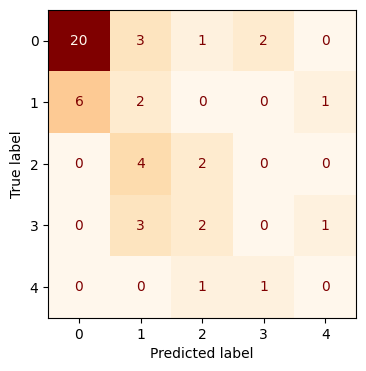

In [303]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels
y_true = test1.iloc[:, -2] 

# Predicted labels
y_pred = test1.iloc[:, -1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap="OrRd", ax=ax, colorbar=False)
plt.show()

In [304]:
from sklearn.metrics import classification_report

# Display classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        26
           1       0.17      0.22      0.19         9
           2       0.33      0.33      0.33         6
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.49        49
   macro avg       0.25      0.26      0.26        49
weighted avg       0.48      0.49      0.48        49

